In [6]:
#| echo: false
import torch
import matplotlib.pyplot as plt

<https://karpathy.ai/zero-to-hero.html>

# Parameter Initialization

Poor initialization of model weights can be problematic in at least two different cases:

## 1. Final Layer Bias Initilization
It can be common to see a "hockey stick" plot when analyzing the loss plots of a
neural network for the first few iterations. This happens when network is first
learning to scale the logits into the same range as the labels.

To mitigate this, the bias of the final layer can be set based on the type of ML task, and the
balance of the dataset used. For the example of Makemore, Andrej sets the bias to zero
to correspond to a uniform distribution. He could have also investigated the
distribution of letters in the dataset and set the bias according to that - this
is kind of like Empirical Bayes!

For other cases, Andrej provides advice in his [recipe for training neural nets](https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines):

> * **init well.** Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.


## 2. Weight Initialization
Large values in matrices in pre-activation states can lead to strange behaviour
when passed through activation functions. For example, activation functions that
have asymptotic areas (tanh, sigmoid) can "saturate", leading to a high number
of outputs which are either 0 or 1. This can cause more problems in deep
networks. Ideally we want activations in the network to stay within the unit
Gaussian range - mean of 0, std of 1

We can fix this be initializing weights intelligently. In theory, this can be
done manually by scaling down randomly initialized weights, and inspecting the
effects on the distribution of activations. However this approach is not
scalable to larger networks.

He (AKA Kaiming) Initialization is a more principled way of doing this. It is
based on a mathematical analysis of the effects on the statistical changes made
by activation functions. 

This is functionally the same as what Andrej shows in the lecture - dividing the
unit gaussian weights by $gain * \sqrt{n_l}$, where
$n_l$ is the "fan-in", the number of inputs to the layer, and $gain$ is an
activation specific constant. These constants are defined [in pytorch too](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain):

| nonlinearity      | gain                                                                                |
|-------------------|-------------------------------------------------------------------------------------|
| Linear / Identity | 1                                                                                   |
| Conv{1,2,3}D      | 1                                                                                 |
| Sigmoid           | 11                                                                              |
| Tanh              | $\frac{5}{3}$​                                                                    |
| ReLU              | $\sqrt{2}$​                                                                         |
| Leaky Relu        | $\sqrt{\frac{2}{1 + \text{negative\_slope}^2}}$​​ |
| SELU              | $\frac{3}{4}$                                                                  |

The paper first describing this: [Delving Deep into Rectifiers: Surpassing
Human-Level Performance on ImageNet Classification - He, K. et al. (2015)
](https://arxiv.org/abs/1502.01852)

### Worked example

Lets imagine some neuron inputs `x` and neuron weights `w`. We can calculate the
matrix product `y` before passing the resulting values through and activation
function RELU to get some activations. When we compare the standard deviation in
`h` to `x` we can see there has been an increase.

tensor(0.9962) tensor(2.5542)


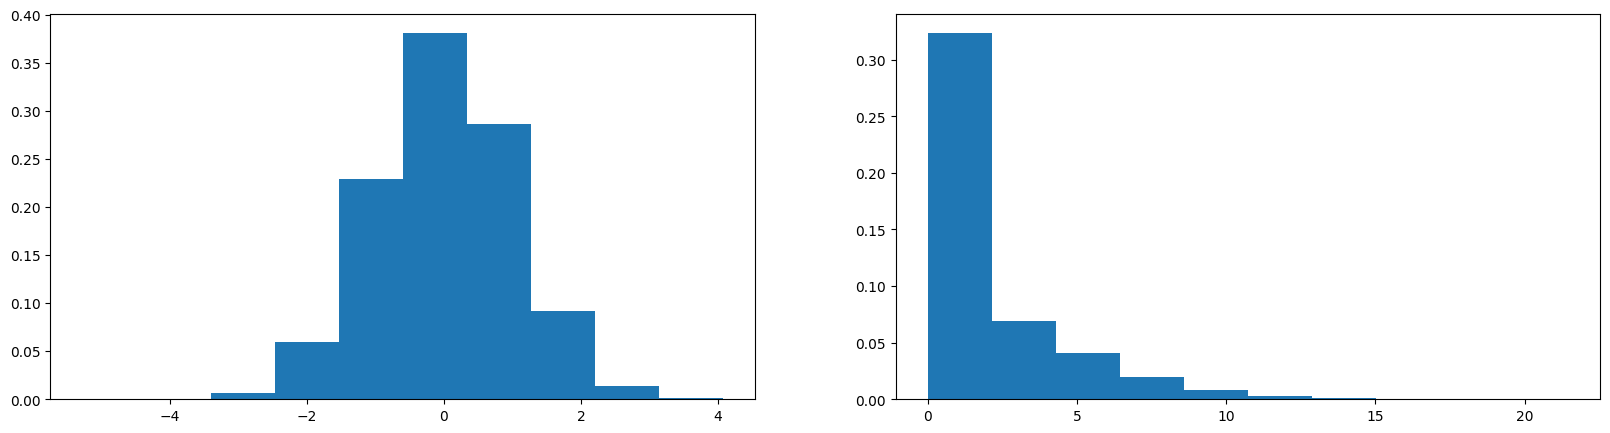

In [ ]:
x = torch.randn(1000, 20) # inputs
w = torch.randn(20, 200) # neuron weights
y = x @ w
h = torch.relu(y)


print(x.std(), h.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1), density=True);
plt.subplot(122)
plt.hist(h.view(-1), density=True);

`torch.randn` draws values from a unit normal distribution, $\mu=0, \sigma=1$ - so we can change
the standard deviation by scaling it by a factor. For RELU, our Kaiming
initialization should have $\sigma = \sqrt{\frac{2}{n_l}}$, where $n_l$ is the
"fan-in" - the number of inputs to the neuron

tensor(0.9962) tensor(0.8292)


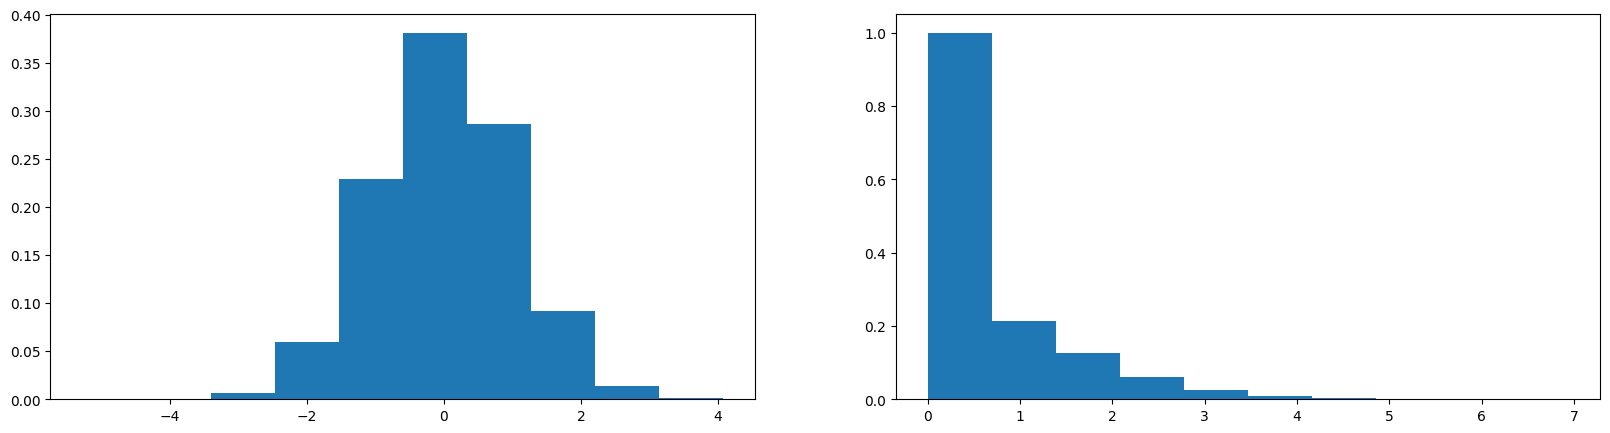

In [44]:
w = torch.randn(20, 200) * (2 / 20)**0.5 # init w with He Initialization
y = x @ w # x is fixed from above
h = torch.relu(y)

print(x.std(), h.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1), density=True);
plt.subplot(122)
plt.hist(h.view(-1), density=True);

We can see that this has reduced the standard deviation of the activations,
closer to the range of unit normal (although obviously the output of RELU is
not normally distributed)

::: {.callout-note collapse="true" title="NOTE: Default parameter initialization in `torch.nn.Linear`"}
When taking a look at the source code of `nn.Linear`, it might seem like they are
using the Kaiming init:

```python
def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
```

However from the comment it becomes clear that actually they are using the
`nn.init.kaiming_uniform_` function as a hack to achieve values from the uniform
distribution $U(-1/\sqrt(in\_features), 1/\sqrt(in\_features))$

To me it seems strange that they are not using an init defined in `nn.init` for
this...

Delving [into the pytorch forums](https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/33), it seems that this default init scheme is non standard:

> <div class="cooked"><p><a href="https://discuss.pytorch.org/t/whats-the-default-initialization-methods-for-layers/3157/17">One answer in this older thread</a> suggests that the initialisation resembles what is referred to “LeCun Initialisation”. This comment is probably long overdue, but pytorch does not implement LeCun <strong>or</strong> He/Kaiming initialisation for the <code>Linear</code> module.</p>
<p>If we go through the code (v1.5.0) of <code>Linear.reset_parameters</code>, the first line initialises the weight matrix:<br>
<code>init.kaiming_uniform_(self.weight, a=math.sqrt(5))</code>. If we take a look at how <code>kaiming_uniform</code> is implemented, we find that this line is equivalent to</p>
<pre><code class="hljs language-lua">fan = tensor.size(<span class="hljs-number">1</span>)  # fan-<span class="hljs-keyword">in</span> <span class="hljs-keyword">for</span> linear, as computed by _calculate_correct_fan
gain = <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(<span class="hljs-number">2.0</span> / (<span class="hljs-number">1</span> + a ** <span class="hljs-number">2</span>))  # gain, as computed by calculate_gain
std = gain / <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(fan)
bound = <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(<span class="hljs-number">3.0</span>) * std
with torch.no_grad():
    <span class="hljs-keyword">return</span> tensor.uniform_(-bound, bound)
</code></pre>
<p>Since <code>a = math.sqrt(5)</code> the weights are initialised with <code>std = 1 / math.sqrt(3.0 * fan_in)</code>. For reference, LeCun initialisation would be <code>1 / math.sqrt(fan_in)</code> and He initialisation uses <code>math.sqrt(2 / fan_in)</code>.</p>
<p>The bias initialisation in <code>Linear.reset_parameters</code> reveals another problem. Although biases are normally initialised with zeros (for the sake of simplicity), the idea is probably to initialise the biases with <code>std = math.sqrt(1 / fan_in)</code> (cf. LeCun init). By using this value for the boundaries of the uniform distribution, the resulting distribution has std <code>math.sqrt(1 / 3.0 * fan_in)</code>, which happens to be the same as the standard deviation for the weights.</p>
<p>A more reasonable default for me would be to use LeCun initialisation (since this has been the go-to standard since 1998). I could also understand Kaiming initialisation as the default, because everyone is using ReLU activation functions everywhere anyway (although I have a feeling that this is not necessarily the case for people working with fully connected networks). Some time ago, I submitted a <a href="https://github.com/pytorch/pytorch/pull/14034" rel="nofollow noopener">pull request</a> to adopt LeCun initialisation as the default, but there seems to be little incentive to actually make changes due to backward compatibility.</p>
<p>This probably also explains why pytorch ended up with its own initialisation strategy for fully connected networks. Someone must have forgotten about the fact that a uniform distribution with bounds <code>-b, b</code> has a standard deviation of <code>b / math.sqrt(3)</code> instead of just <code>b</code>. Due to backwards compatibility this got stuck and no-one is willing to make the change to the more widely accepted and standard initialisation.</p></div>
:::

## Bias Initialization
For biases not in the final layer, both Kaiming Initialization and other regimes
set the bias to 0

# Batch Normalization
This methodology was proposed in 2015 to address issues with the stability of
training deeper models.

In effect:

$$ \mu = \frac{\sum_{i=1}^{n}x_i}{n} $$

$$ \sigma = \sqrt\frac{\sum_{i=1}^{n} (x_i - \mu)^2}{n}$$

$$ x_{scaled} = \frac{x_i - \mu}{\sigma + \epsilon} $$ 
(a very small epsilon value is used to avoid divide by zero issues)

$$ y_{out} = \gamma x_{scaled} + \beta$$

$\gamma$ and $\beta$ are parameters learned as part of the optimisation process,
and they restore the representation power of the network after the centering and
scaling 

This is done vector-wise, meaning that the mean and standard deviation are calculated
for all weights across a batch.

One problem with this approach is that it couples together all
samples within a batch when it comes to backpropogation. It can also
be the source of painful bugs when used in the wild.

Since then, numerous other methods have been proposed to try and address these
issues, eg. Layer Normalization